In [1]:
import scanpy as sc
#from cellbender.remove_background.downstream import anndata_from_h5
import pandas as pd
import numpy as np
import scipy.sparse
import scipy.cluster.hierarchy as shc
from scipy import stats
from scipy.sparse import csr_matrix, hstack
import os
import anndata
import time
import SEACells
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import matplotlib.pyplot as plt
from upsetplot import plot
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import warnings
from scipy.stats import pearsonr, spearmanr
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['font.family'] = 'sans-serif' 

np.random.seed(1966)


In [2]:
pd.set_option('display.max_columns', 50)

## Read peaksets (Short-term, Long-term)

In [3]:
import pickle
with open('../intermediate_outputs3/sc_data/Y1_nrpeakset.pickle', 'rb') as file:
    ad_norm = pickle.load(file)

In [ ]:
# Read BED files for different peak categories and store peak region names
bed_df = pd.read_table('/data/peer/sotougl/final_outs/peak_sets/D30_memory_M12_resolved.bed',
                       sep='\t', names = ['Chromosome', 'Start', 'End', 'A', 'B', 'C'] ,  header=None)
bed_df['Start'] = bed_df['Start'] + 1
bed_df['Name'] = bed_df['Chromosome'] + ':' + bed_df['Start'].astype(str) + '-' + bed_df['End'].astype(str)
short_term_memory_peaks = bed_df['Name'].to_list()

bed_df = pd.read_table('/data/peer/sotougl/final_outs/peak_sets/D6_induced_D30_resolved.bed', sep='\t', names = ['Chromosome', 'Start', 'End', 'A', 'B', 'C'] ,  header=None)
bed_df['Start'] = bed_df['Start'] + 1
bed_df['Name'] = bed_df['Chromosome'] + ':' + bed_df['Start'].astype(str) + '-' + bed_df['End'].astype(str)
resolved_peaks = bed_df['Name'].to_list()


bed_df = pd.read_table('/data/peer/sotougl/final_outs/peak_sets/unchanged_downsampled.bed', sep='\t', names = ['Chromosome', 'Start', 'End', 'A', 'B', 'C'] ,  header=None)
bed_df['Start'] = bed_df['Start'] + 1
bed_df['Name'] = bed_df['Chromosome'] + ':' + bed_df['Start'].astype(str) + '-' + bed_df['End'].astype(str)
unchanged_peaks = bed_df['Name'].to_list()


bed_df = pd.read_table('/data/peer/sotougl/final_outs/peak_sets/D30_M12_memory.bed', sep='\t', names = ['Chromosome', 'Start', 'End', 'A', 'B', 'C'] ,  header=None)
bed_df['Start'] = bed_df['Start'] + 1
bed_df['Name'] = bed_df['Chromosome'] + ':' + bed_df['Start'].astype(str) + '-' + bed_df['End'].astype(str)
long_term_memory_peaks = bed_df['Name'].to_list()

bed_df = pd.read_table('/data/peer/sotougl/final_outs/peak_sets/D30_memory.bed', sep='\t', names = ['Chromosome', 'Start', 'End', 'A', 'B', 'C'] ,  header=None)
bed_df['Start'] = bed_df['Start'] + 1
bed_df['Name'] = bed_df['Chromosome'] + ':' + bed_df['Start'].astype(str) + '-' + bed_df['End'].astype(str)
all_memory_peaks = bed_df['Name'].to_list()


In [ ]:
# Create a DataFrame to annotate peaks with their memory categories
peak_info = pd.DataFrame({'Peak':  ad_norm.var_names})

peak_info['st_memory'] = 'No' 
peak_info['lt_memory'] = 'No' 
peak_info['resolved'] = 'No' 
peak_info['unchanged'] = 'No' 
peak_info['all_memory'] = 'No' 

peak_info.loc[peak_info['Peak'].isin(short_term_memory_peaks) , 'st_memory'] = 'Yes'
peak_info.loc[peak_info['Peak'].isin(resolved_peaks) , 'resolved'] = 'Yes'
peak_info.loc[peak_info['Peak'].isin(unchanged_peaks) , 'unchanged'] = 'Yes'
peak_info.loc[peak_info['Peak'].isin(long_term_memory_peaks) , 'lt_memory'] = 'Yes'
peak_info.loc[peak_info['Peak'].isin(all_memory_peaks) , 'all_memory'] = 'Yes'

# Function to determine the peak category (priority order)
def determine_peak_category(row):
    if row['st_memory'] == 'Yes':
        return 'st_memory'
    elif row['resolved'] == 'Yes':
        return 'resolved'
    elif row['unchanged'] == 'Yes':
        return 'unchanged'
    elif row['lt_memory'] == 'Yes':
        return 'lt_memory'
    elif row['all_memory'] == 'Yes':
        return 'all_memory'
    else:
        return 'None'

peak_info['category'] = peak_info.apply(determine_peak_category, axis=1)

peak_info


,Peak,st_memory,lt_memory,resolved,unchanged,all_memory,category
0,chr1:3398914-3399468,No,No,No,No,No,None
1,chr1:3399887-3400441,No,No,No,No,No,None
2,chr1:3611111-3611673,No,No,No,No,No,None
3,chr1:3669622-3669927,No,No,No,No,No,None
4,chr1:3670480-3672669,No,No,No,No,No,None
...,...,...,...,...,...,...,...
220879,chrX:170004195-170004751,No,No,No,No,No,None
220880,chrX:170004822-170005868,No,No,No,No,No,None
220881,chrX:170673318-170673882,No,No,No,No,No,None
220882,chrX:170674214-170677855,No,No,No,No,No,None


## D30 scATAC

In [6]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

In [7]:
import pickle
with open('../intermediate_outputs3/sc_data/D30_nrpeakset.pickle', 'rb') as file:
    ad_norm = pickle.load(file)

In [ ]:
# Convert the AnnData matrix to a DataFrame and z-score each peak across cells (D30)
d30_zscore_matrix = ad_norm.to_df()
d30_zscore_matrix = (d30_zscore_matrix - d30_zscore_matrix.mean()) / d30_zscore_matrix.std()

In [ ]:
# Collect SEACell/sample names for each condition and cell type (D30)
day30_control_ub_cells = list(ad_norm[ad_norm.obs['condition_celltype'] == 'Control_UB'].obs_names)
day30_control_db_cells = list(ad_norm[ad_norm.obs['condition_celltype'] == 'Control_DB'].obs_names)
day30_control_uhf_cells = list(ad_norm[ad_norm.obs['condition_celltype'] == 'Control_uHF'].obs_names)
day30_pimq_ub_cells = list(ad_norm[ad_norm.obs['condition_celltype'] == 'PIMQ_UB'].obs_names)
day30_pimq_db_cells = list(ad_norm[ad_norm.obs['condition_celltype'] == 'PIMQ_DB'].obs_names)
day30_pimq_uhf_cells = list(ad_norm[ad_norm.obs['condition_celltype'] == 'PIMQ_uHF'].obs_names)
print(len(day30_control_ub_cells + day30_pimq_ub_cells),
     len(day30_control_db_cells + day30_pimq_db_cells),
     len(day30_control_uhf_cells + day30_pimq_uhf_cells))

80 27 36


In [ ]:
# Export z-scored accessibility matrices for each group and memory peak category (D30)
peak_type = 'lt_memory'
peak_subset = d30_zscore_matrix.loc[day30_control_ub_cells + day30_pimq_ub_cells,
                   peak_info[peak_info[peak_type] == 'Yes']['Peak'].values]
peak_subset.to_excel('D30_UB_LT_scATAC.xlsx')

peak_type = 'st_memory'
peak_subset = d30_zscore_matrix.loc[day30_control_ub_cells + day30_pimq_ub_cells,
                   peak_info[peak_info[peak_type] == 'Yes']['Peak'].values]
peak_subset.to_excel('D30_UB_ST_scATAC.xlsx')


peak_type = 'lt_memory'
peak_subset = d30_zscore_matrix.loc[day30_control_db_cells + day30_pimq_db_cells,
                   peak_info[peak_info[peak_type] == 'Yes']['Peak'].values]
peak_subset.to_excel('D30_DB_LT_scATAC.xlsx')

peak_type = 'st_memory'
peak_subset = d30_zscore_matrix.loc[day30_control_db_cells + day30_pimq_db_cells,
                   peak_info[peak_info[peak_type] == 'Yes']['Peak'].values]
peak_subset.to_excel('D30_DB_ST_scATAC.xlsx')


peak_type = 'lt_memory'
peak_subset = d30_zscore_matrix.loc[day30_control_uhf_cells + day30_pimq_uhf_cells,
                   peak_info[peak_info[peak_type] == 'Yes']['Peak'].values]
peak_subset.to_excel('D30_uHF_LT_scATAC.xlsx')

peak_type = 'st_memory'
peak_subset = d30_zscore_matrix.loc[day30_control_uhf_cells + day30_pimq_uhf_cells,
                   peak_info[peak_info[peak_type] == 'Yes']['Peak'].values]
peak_subset.to_excel('D30_uHF_ST_scATAC.xlsx')


<Figure size 500x400 with 0 Axes>

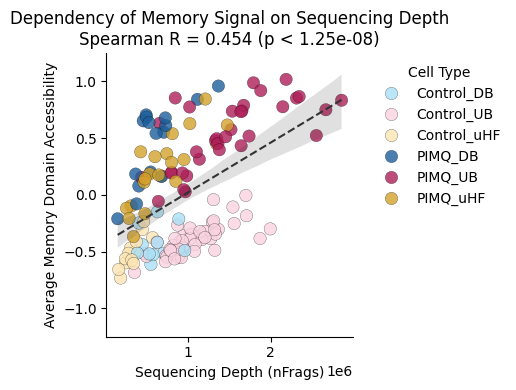

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd

# Prepare a DataFrame to correlate sequencing depth (nFrags) with mean memory-peak accessibility
peak_type = 'all_memory'
memory_peaks = peak_info[peak_info[peak_type] == 'Yes']['Peak'].values

# Assumes `d30_zscore_matrix` (z-scored accessibility) and `ad_norm` are defined in the notebook
correlation_df = pd.DataFrame({
    'memory_signal': d30_zscore_matrix.loc[:, memory_peaks].mean(axis=1),
    'nFrags': ad_norm.obs['nFrags'].values,
    'condition': ad_norm.obs['Condition'].values,
    'celltype': ad_norm.obs['celltype'].values,
    'condition_celltype': ad_norm.obs['condition_celltype'].values
})

# Spearman correlation
r_spearman, p_val = stats.spearmanr(correlation_df['nFrags'], correlation_df['memory_signal'])

# Color palette for condition/celltype groups
palette_dict = {
    'Control_UB': '#fad3e0',
    'PIMQ_UB': '#ae1f59',
    'Control_DB': '#aae0f5',
    'PIMQ_DB': '#1d5e9a',
    'Control_uHF': '#fde5b4',
    'PIMQ_uHF': '#d3a12a'
}

# Plot
plt.figure(figsize=(5, 4))
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd

# ... (Steps 1, 2 and 3 are unchanged) ...
# Assumes `correlation_df`, `r_spearman`, `p_val` and `palette_dict` are already defined

plt.figure(figsize=(5, 4))

# Layer A: points (biology)
sns.scatterplot(
    data=correlation_df,
    x='nFrags',
    y='memory_signal',
    hue='condition_celltype',
    s=80,
    palette=palette_dict,
    alpha=0.8,
    edgecolor='k',
    linewidth=0.2,
    zorder=1  # points in the background
)

# Layer B: correlation line + confidence interval (technical)
sns.regplot(
    data=correlation_df,
    x='nFrags',
    y='memory_signal',
    scatter=False,         # do not draw extra points
    color='.2',            # line color
    ci=95,                 # confidence interval
    # Moved: zorder must go inside line_kws to affect the line
    line_kws={'linestyle': '--', 'linewidth': 1.5, 'zorder': 2}
)

# Labels and formatting
plt.ylim(-1.25, 1.25)
plt.title(
    f'Dependency of Memory Signal on Sequencing Depth\n'
    f'Spearman R = {r_spearman:.3f} (p < {p_val:.2e})'
)
plt.xlabel('Sequencing Depth (nFrags)')
plt.ylabel('Average Memory Domain Accessibility')

# Legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False, title='Cell Type')
plt.tight_layout()
plt.savefig("FragsVsMemory_Correlation.pdf", bbox_inches='tight', dpi=300)
plt.show()

Correlación PC1 vs nFrags: 0.446


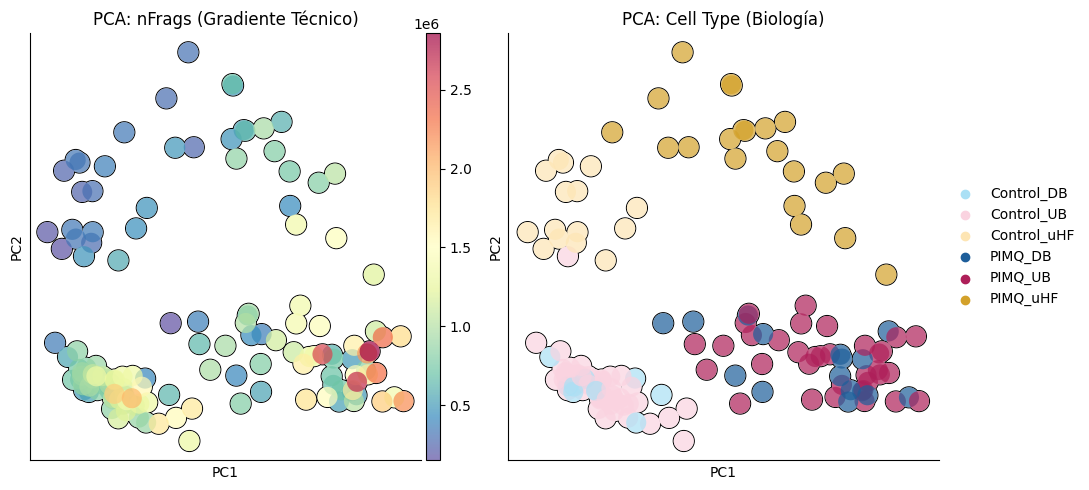

In [ ]:
import scanpy as sc
import numpy as np

# Subset only memory peaks into a smaller AnnData object
memory_peaks_names = peak_info[peak_info[peak_type] == 'Yes']['Peak'].values
ad_memory = ad_norm[:, memory_peaks_names].copy()

# Run PCA
sc.pp.pca(ad_memory)

# Correlate PC1 with nFrags
pc1_values = ad_memory.obsm['X_pca'][:, 0]
corr_pc1_nfrags = stats.spearmanr(pc1_values, ad_memory.obs['nFrags'])[0]

print(f"PC1 vs nFrags Spearman correlation: {corr_pc1_nfrags:.3f}")

# Visualize PCA colored by technical depth vs biology
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
sc.pl.pca(
    ad_memory,
    color='nFrags',
    ax=ax1,
    show=False,
    title='PCA: nFrags (technical gradient)',
    add_outline=True,
    outline_width=(0.05, 0.001)
)
sc.pl.pca(
    ad_memory,
    color='condition_celltype',
    ax=ax2,
    show=False,
    title='PCA: Cell Type (biology)',
    palette=palette_dict,
    add_outline=True,
    outline_width=(0.05, 0.001)
)
plt.tight_layout()
plt.savefig("FragsVsMemory_PCA.pdf", bbox_inches='tight', dpi=300)
plt.show()

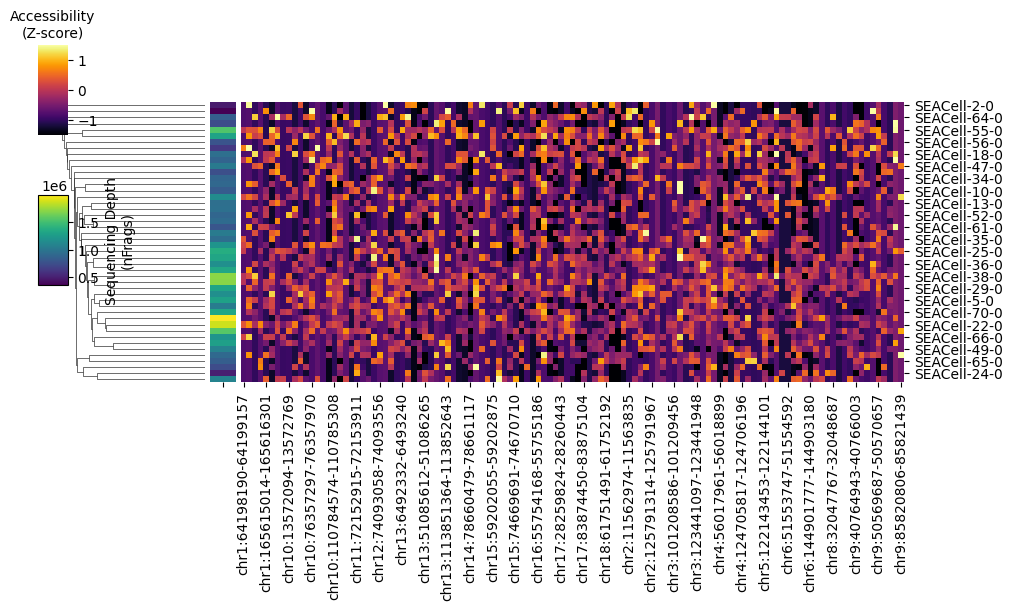

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# --- Data configuration (existing logic) ---
peak_type = 'lt_memory'

# 1) Subset data (rows = samples, columns = peaks)
peak_subset = d30_zscore_matrix.loc[
    day30_control_ub_cells,
    peak_info[peak_info[peak_type] == 'Yes']['Peak'].values
]

# 2) Extract nFrags for the same samples
adata_subset = ad_norm[ad_norm.obs.index.isin(day30_control_ub_cells)]
nfrags_series = adata_subset.obs.loc[peak_subset.index, 'nFrags']

# 3) Normalize nFrags to build row_colors
nfrags_norm = Normalize(vmin=nfrags_series.min(), vmax=nfrags_series.max())
cmap_nfrags = plt.cm.viridis
colors_nfrags = pd.Series(
    [cmap_nfrags(nfrags_norm(val)) for val in nfrags_series],
    index=nfrags_series.index
)

# --- Plot ---
g = sns.clustermap(
    peak_subset,
    cmap="inferno",
    col_cluster=False,
    row_colors=colors_nfrags,
    vmin=-1.5,
    vmax=1.5,
    figsize=(10, 6),
    metric="euclidean",
    method="average",
    # Move the main heatmap colorbar to make space if needed
    cbar_pos=(0.02, 0.8, 0.03, 0.15)  # [left, bottom, width, height]
)

# Title for the main colorbar (accessibility)
g.ax_cbar.set_title("Accessibility\n(Z-score)", fontsize=10)

# Add a separate colorbar for nFrags
# 1) Create a ScalarMappable so matplotlib can render the colorbar
sm = ScalarMappable(cmap=cmap_nfrags, norm=nfrags_norm)
sm.set_array([])  # required for colorbar

# 2) Add an axis for the nFrags colorbar
cax_nfrags = g.fig.add_axes([0.02, 0.55, 0.03, 0.15])

# 3) Draw the colorbar
cbar = g.fig.colorbar(sm, cax=cax_nfrags, orientation='vertical')
cbar.set_label('Sequencing Depth\n(nFrags)', fontsize=10)

# --- Save ---
plt.savefig(
    "../pdf_plots/D30Ctrl_UB_LT_clustered_nFrags_showScale.pdf",
    format="pdf",
    bbox_inches="tight"
)
plt.show()

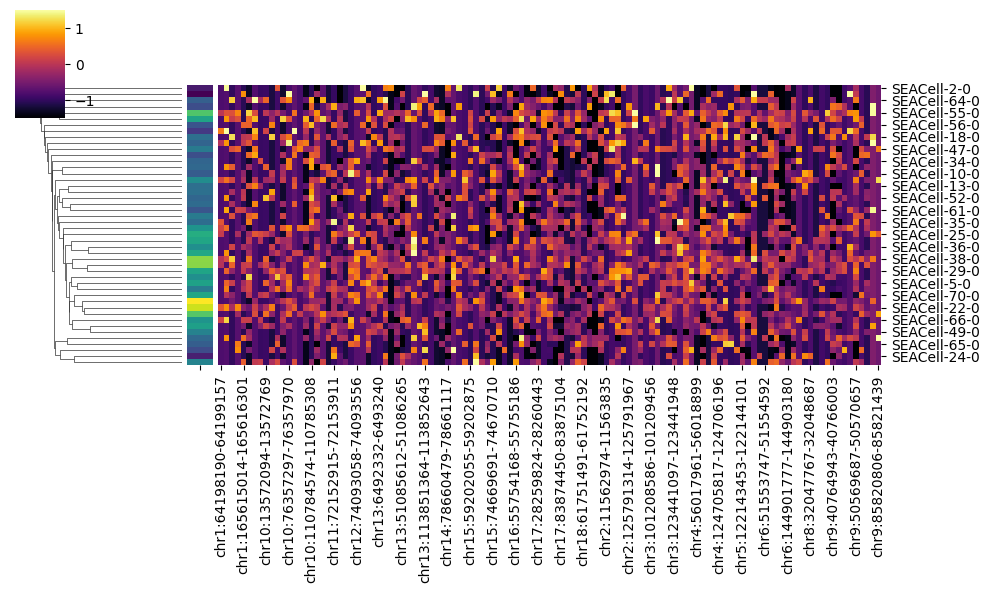

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

peak_type = 'lt_memory'

# Subset data (rows = samples, columns = peaks)
peak_subset = d30_zscore_matrix.loc[
    day30_control_ub_cells,
    peak_info[peak_info[peak_type] == 'Yes']['Peak'].values
]

# Extract nFrags for the same samples
adata_subset = ad_norm[ad_norm.obs.index.isin(day30_control_ub_cells)]
nfrags_series = adata_subset.obs.loc[peak_subset.index, 'nFrags']

# Normalize nFrags to build row_colors
from matplotlib.colors import Normalize

nfrags_norm = Normalize(vmin=nfrags_series.min(), vmax=nfrags_series.max())
cmap_nfrags = plt.cm.viridis
colors_nfrags = pd.Series(
    [cmap_nfrags(nfrags_norm(val)) for val in nfrags_series],
    index=nfrags_series.index
)

# Create the clustermap with nFrags as row_colors
sns.clustermap(
    peak_subset,
    cmap="inferno",
    col_cluster=False,
    row_colors=colors_nfrags,
    vmin=-1.5,
    vmax=1.5,
    figsize=(10, 6),
    metric="euclidean",
    method="average"
)

plt.savefig("../pdf_plots/D30Ctrl_UB_LT_clustered_nFrags.pdf", format="pdf", bbox_inches="tight")
plt.show()

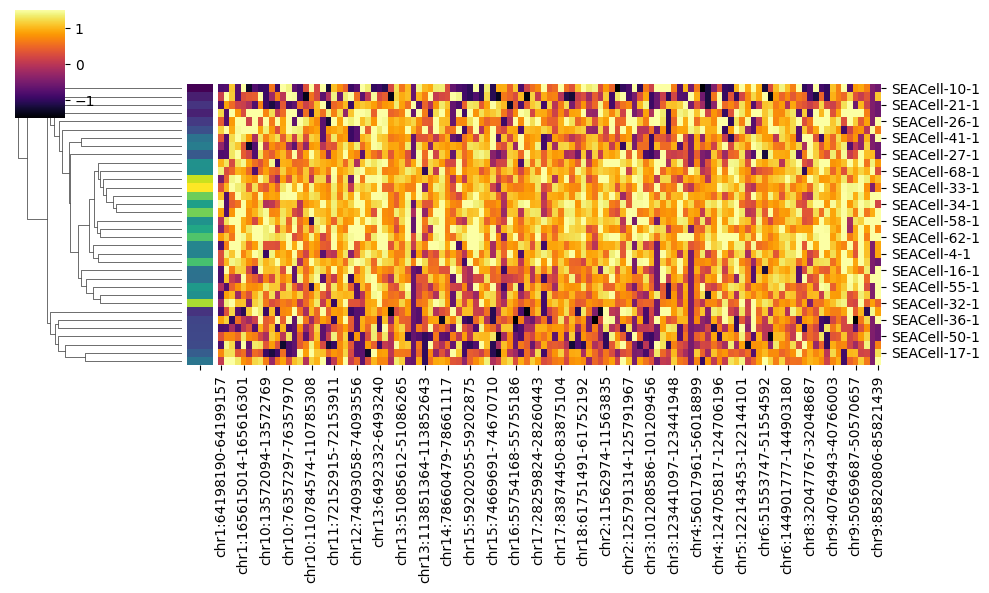

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

peak_type = 'lt_memory'

# Subset data (rows = samples, columns = peaks)
peak_subset = d30_zscore_matrix.loc[
    day30_pimq_ub_cells,
    peak_info[peak_info[peak_type] == 'Yes']['Peak'].values
]

# Extract nFrags for the same samples
adata_subset = ad_norm[ad_norm.obs.index.isin(day30_pimq_ub_cells)]
nfrags_series = adata_subset.obs.loc[peak_subset.index, 'nFrags']

# Normalize nFrags to build row_colors
from matplotlib.colors import Normalize

nfrags_norm = Normalize(vmin=nfrags_series.min(), vmax=nfrags_series.max())
cmap_nfrags = plt.cm.viridis
colors_nfrags = pd.Series(
    [cmap_nfrags(nfrags_norm(val)) for val in nfrags_series],
    index=nfrags_series.index
)

# Create the clustermap with nFrags as row_colors
sns.clustermap(
    peak_subset,
    cmap="inferno",
    col_cluster=False,
    row_colors=colors_nfrags,
    vmin=-1.5,
    vmax=1.5,
    figsize=(10, 6),
    metric="euclidean",
    method="average"
)

plt.savefig("../pdf_plots/D30PIMQ_UB_LT_clustered_nfrags.pdf", format="pdf", bbox_inches="tight")
plt.show()

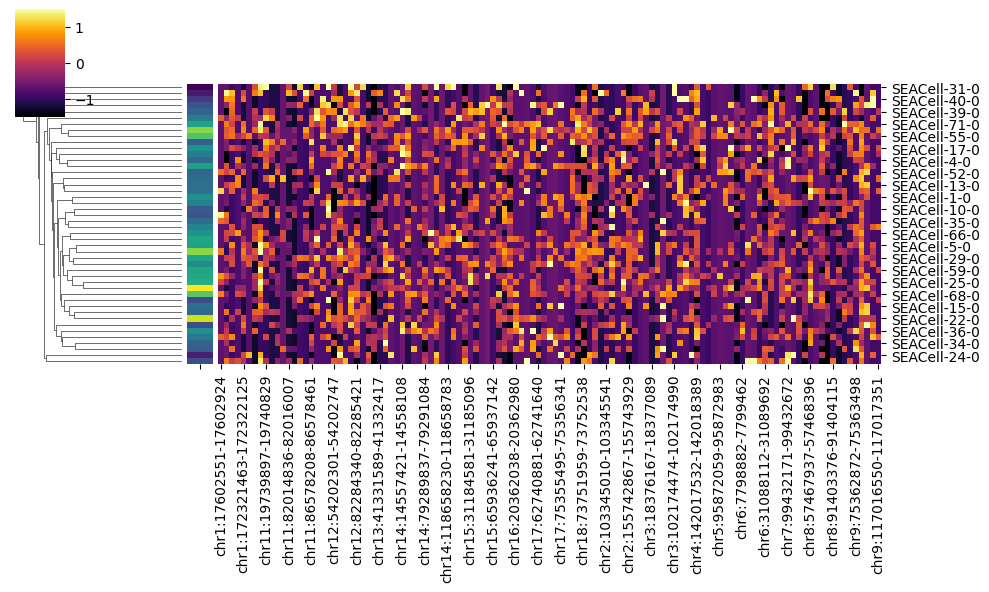

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

peak_type = 'st_memory'

# Subset data (rows = samples, columns = peaks)
peak_subset = d30_zscore_matrix.loc[
    day30_control_ub_cells,
    peak_info[peak_info[peak_type] == 'Yes']['Peak'].values
]

# Extract nFrags for the same samples
adata_subset = ad_norm[ad_norm.obs.index.isin(day30_control_ub_cells)]
nfrags_series = adata_subset.obs.loc[peak_subset.index, 'nFrags']

# Normalize nFrags to build row_colors
from matplotlib.colors import Normalize

nfrags_norm = Normalize(vmin=nfrags_series.min(), vmax=nfrags_series.max())
cmap_nfrags = plt.cm.viridis
colors_nfrags = pd.Series(
    [cmap_nfrags(nfrags_norm(val)) for val in nfrags_series],
    index=nfrags_series.index
)

# Create the clustermap with nFrags as row_colors
sns.clustermap(
    peak_subset,
    cmap="inferno",
    col_cluster=False,
    row_colors=colors_nfrags,
    vmin=-1.5,
    vmax=1.5,
    figsize=(10, 6),
    metric="euclidean",
    method="average"
)

plt.savefig("../pdf_plots/D30Ctrl_UB_ST_clustered_nfrags.pdf", format="pdf", bbox_inches="tight")
plt.show()

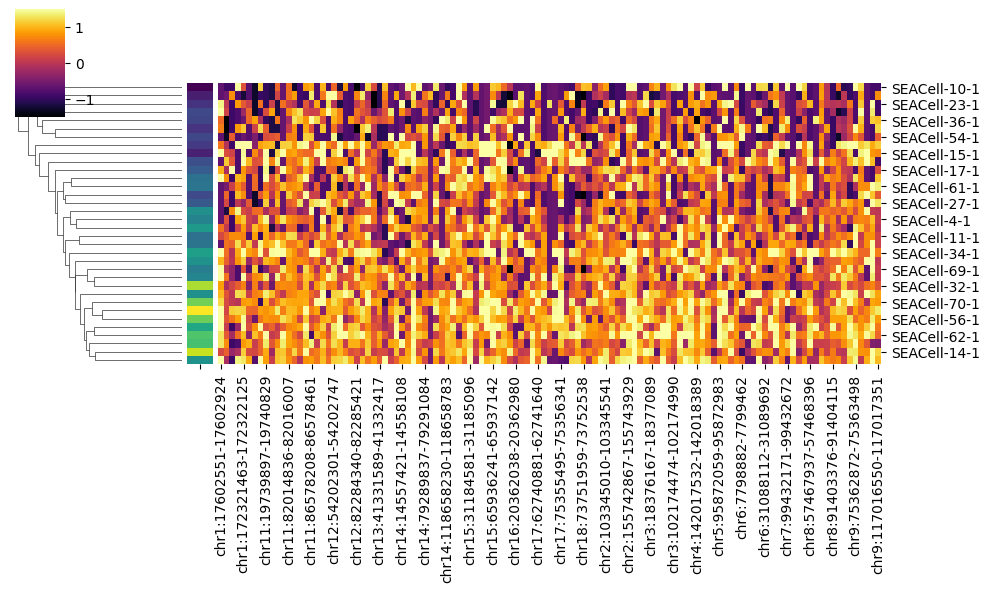

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

peak_type = 'st_memory'

# Subset data (rows = samples, columns = peaks)
peak_subset = d30_zscore_matrix.loc[
    day30_pimq_ub_cells,
    peak_info[peak_info[peak_type] == 'Yes']['Peak'].values
]

# Extract nFrags for the same samples
adata_subset = ad_norm[ad_norm.obs.index.isin(day30_pimq_ub_cells)]
nfrags_series = adata_subset.obs.loc[peak_subset.index, 'nFrags']

# Normalize nFrags to build row_colors
from matplotlib.colors import Normalize

nfrags_norm = Normalize(vmin=nfrags_series.min(), vmax=nfrags_series.max())
cmap_nfrags = plt.cm.viridis
colors_nfrags = pd.Series(
    [cmap_nfrags(nfrags_norm(val)) for val in nfrags_series],
    index=nfrags_series.index
)

# Create the clustermap with nFrags as row_colors
sns.clustermap(
    peak_subset,
    cmap="inferno",
    col_cluster=False,
    row_colors=colors_nfrags,
    vmin=-1.5,
    vmax=1.5,
    figsize=(10, 6),
    metric="euclidean",
    method="average"
)

plt.savefig("../pdf_plots/D30PIMQ_UB_ST_clustered_nfrags.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Year 1 scATAC

In [34]:
import pickle
with open('../intermediate_outputs3/sc_data/Y1_nrpeakset.pickle', 'rb') as file:
    ad_norm = pickle.load(file)

In [ ]:
# Convert the AnnData object to a DataFrame and z-score per peak (column-wise)
year1_zscore_matrix = ad_norm.to_df()
year1_zscore_matrix = (year1_zscore_matrix - year1_zscore_matrix.mean()) / year1_zscore_matrix.std()

In [ ]:
# Split Year 1 cells by condition and cell type
year1_control_ub_cells = list(ad_norm[ad_norm.obs['condition_celltype'] == 'Control_UB'].obs_names)
year1_control_db_cells = list(ad_norm[ad_norm.obs['condition_celltype'] == 'Control_DB'].obs_names)
year1_control_uhf_cells = list(ad_norm[ad_norm.obs['condition_celltype'] == 'Control_uHF'].obs_names)
year1_pimq_ub_cells = list(ad_norm[ad_norm.obs['condition_celltype'] == 'PIMQ_UB'].obs_names)
year1_pimq_db_cells = list(ad_norm[ad_norm.obs['condition_celltype'] == 'PIMQ_DB'].obs_names)
year1_pimq_uhf_cells = list(ad_norm[ad_norm.obs['condition_celltype'] == 'PIMQ_uHF'].obs_names)

print(
    len(year1_control_ub_cells + year1_pimq_ub_cells),
    len(year1_control_db_cells + year1_pimq_db_cells),
    len(year1_control_uhf_cells + year1_pimq_uhf_cells)
)

38 13 8


In [ ]:
peak_type = 'lt_memory'
peak_subset = year1_zscore_matrix.loc[
    year1_control_ub_cells + year1_pimq_ub_cells,
    peak_info[peak_info[peak_type] == 'Yes']['Peak'].values
]
peak_subset.to_excel('y1_UB_LT_scATAC.xlsx')

peak_type = 'st_memory'
peak_subset = year1_zscore_matrix.loc[
    year1_control_ub_cells + year1_pimq_ub_cells,
    peak_info[peak_info[peak_type] == 'Yes']['Peak'].values
]
peak_subset.to_excel('y1_UB_ST_scATAC.xlsx')


peak_type = 'lt_memory'
peak_subset = year1_zscore_matrix.loc[
    year1_control_db_cells + year1_pimq_db_cells,
    peak_info[peak_info[peak_type] == 'Yes']['Peak'].values
]
peak_subset.to_excel('y1_DB_LT_scATAC.xlsx')

peak_type = 'st_memory'
peak_subset = year1_zscore_matrix.loc[
    year1_control_db_cells + year1_pimq_db_cells,
    peak_info[peak_info[peak_type] == 'Yes']['Peak'].values
]
peak_subset.to_excel('y1_DB_ST_scATAC.xlsx')


peak_type = 'lt_memory'
peak_subset = year1_zscore_matrix.loc[
    year1_control_uhf_cells + year1_pimq_uhf_cells,
    peak_info[peak_info[peak_type] == 'Yes']['Peak'].values
]
peak_subset.to_excel('y1_uHF_LT_scATAC.xlsx')

peak_type = 'st_memory'
peak_subset = year1_zscore_matrix.loc[
    year1_control_uhf_cells + year1_pimq_uhf_cells,
    peak_info[peak_info[peak_type] == 'Yes']['Peak'].values
]
peak_subset.to_excel('y1_uHF_ST_scATAC.xlsx')

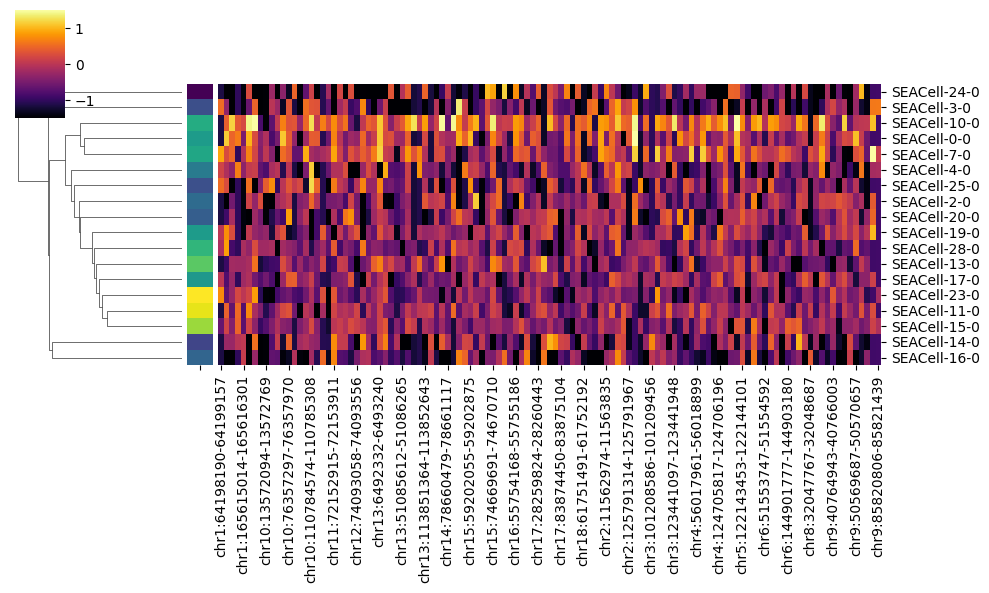

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

peak_type = 'lt_memory'

# Subset data (rows = samples, columns = peaks)
peak_subset = year1_zscore_matrix.loc[
    year1_control_ub_cells,
    peak_info[peak_info[peak_type] == 'Yes']['Peak'].values
]

# Extract nFrags for the same samples
adata_subset = ad_norm[ad_norm.obs.index.isin(year1_control_ub_cells)]
nfrags_series = adata_subset.obs.loc[peak_subset.index, 'nFrags']

# Normalize nFrags to build row_colors
from matplotlib.colors import Normalize

nfrags_norm = Normalize(vmin=nfrags_series.min(), vmax=nfrags_series.max())
cmap_nfrags = plt.cm.viridis
colors_nfrags = pd.Series(
    [cmap_nfrags(nfrags_norm(val)) for val in nfrags_series],
    index=nfrags_series.index
)

# Create the clustermap with nFrags as row_colors
sns.clustermap(
    peak_subset,
    cmap="inferno",
    col_cluster=False,
    row_colors=colors_nfrags,
    vmin=-1.5,
    vmax=1.5,
    figsize=(10, 6),
    metric="euclidean",
    method="average"
)

plt.savefig("../pdf_plots/Y1Ctrl_UB_LT_clustered_nfrags.pdf", format="pdf", bbox_inches="tight")
plt.show()

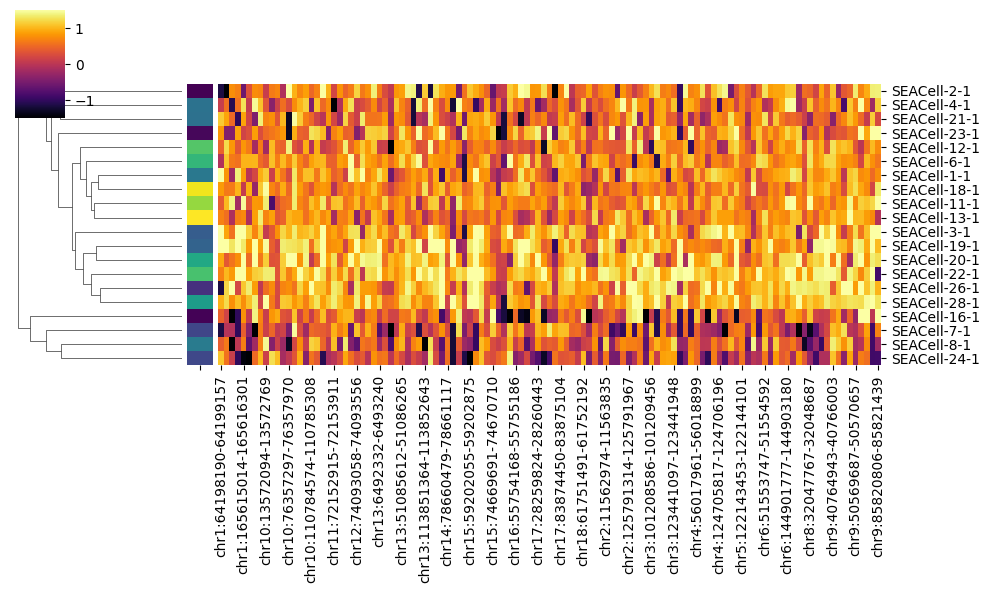

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

peak_type = 'lt_memory'

# Subset data (rows = samples, columns = peaks)
peak_subset = year1_zscore_matrix.loc[
    year1_pimq_ub_cells,
    peak_info[peak_info[peak_type] == 'Yes']['Peak'].values
]

# Extract nFrags for the same samples
adata_subset = ad_norm[ad_norm.obs.index.isin(year1_pimq_ub_cells)]
nfrags_series = adata_subset.obs.loc[peak_subset.index, 'nFrags']

# Normalize nFrags to build row_colors
from matplotlib.colors import Normalize

nfrags_norm = Normalize(vmin=nfrags_series.min(), vmax=nfrags_series.max())
cmap_nfrags = plt.cm.viridis
colors_nfrags = pd.Series(
    [cmap_nfrags(nfrags_norm(val)) for val in nfrags_series],
    index=nfrags_series.index
)

# Create the clustermap with nFrags as row_colors
sns.clustermap(
    peak_subset,
    cmap="inferno",
    col_cluster=False,
    row_colors=colors_nfrags,
    vmin=-1.5,
    vmax=1.5,
    figsize=(10, 6),
    metric="euclidean",
    method="average"
)

plt.savefig("../pdf_plots/Y1PIMQ_UB_LT_clustered_nfrags.pdf", format="pdf", bbox_inches="tight")
plt.show()

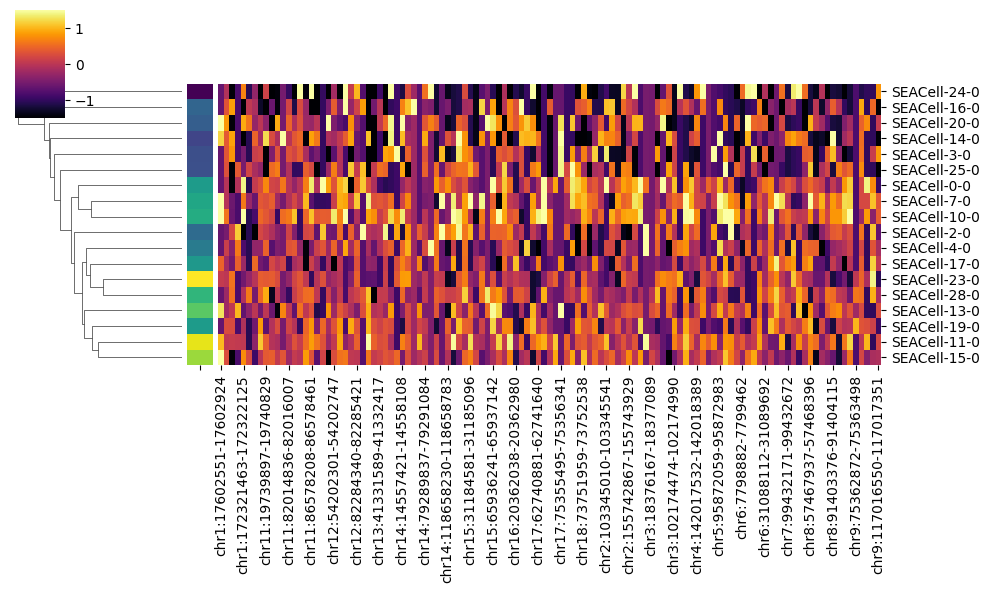

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

peak_type = 'st_memory'

# Subset data (rows = samples, columns = peaks)
peak_subset = year1_zscore_matrix.loc[
    year1_control_ub_cells,
    peak_info[peak_info[peak_type] == 'Yes']['Peak'].values
]

# Extract nFrags for the same samples
adata_subset = ad_norm[ad_norm.obs.index.isin(year1_control_ub_cells)]
nfrags_series = adata_subset.obs.loc[peak_subset.index, 'nFrags']

# Normalize nFrags to build row_colors
from matplotlib.colors import Normalize

nfrags_norm = Normalize(vmin=nfrags_series.min(), vmax=nfrags_series.max())
cmap_nfrags = plt.cm.viridis
colors_nfrags = pd.Series(
    [cmap_nfrags(nfrags_norm(val)) for val in nfrags_series],
    index=nfrags_series.index
)

# Create the clustermap with nFrags as row_colors
sns.clustermap(
    peak_subset,
    cmap="inferno",
    col_cluster=False,
    row_colors=colors_nfrags,
    vmin=-1.5,
    vmax=1.5,
    figsize=(10, 6),
    metric="euclidean",
    method="average"
)

plt.savefig("../pdf_plots/Y1Ctrl_UB_ST_clustered_nfrags.pdf", format="pdf", bbox_inches="tight")
plt.show()

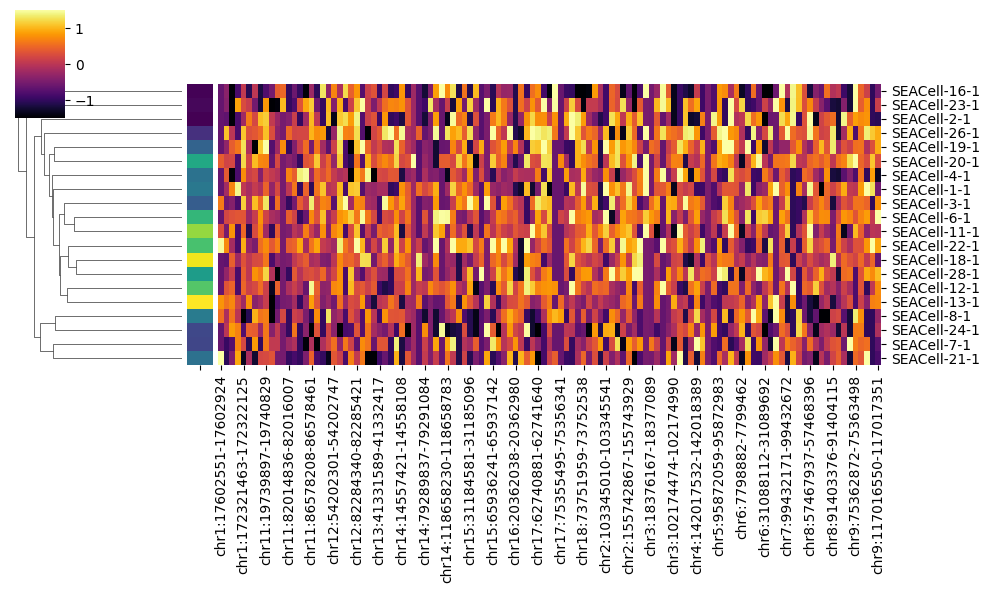

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

peak_type = 'st_memory'

# Subset data (rows = samples, columns = peaks)
peak_subset = year1_zscore_matrix.loc[
    year1_pimq_ub_cells,
    peak_info[peak_info[peak_type] == 'Yes']['Peak'].values
]

# Extract nFrags for the same samples
adata_subset = ad_norm[ad_norm.obs.index.isin(year1_pimq_ub_cells)]
nfrags_series = adata_subset.obs.loc[peak_subset.index, 'nFrags']

# Normalize nFrags to build row_colors
from matplotlib.colors import Normalize

nfrags_norm = Normalize(vmin=nfrags_series.min(), vmax=nfrags_series.max())
cmap_nfrags = plt.cm.viridis
colors_nfrags = pd.Series(
    [cmap_nfrags(nfrags_norm(val)) for val in nfrags_series],
    index=nfrags_series.index
)

# Create the clustermap with nFrags as row_colors
sns.clustermap(
    peak_subset,
    cmap="inferno",
    col_cluster=False,
    row_colors=colors_nfrags,
    vmin=-1.5,
    vmax=1.5,
    figsize=(10, 6),
    metric="euclidean",
    method="average"
)

plt.savefig("../pdf_plots/Y1PIMQ_UB_ST_clustered_nfrags.pdf", format="pdf", bbox_inches="tight")
plt.show()